# **Trabalho 3**

In [2]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 1.3 MB/s 
     |████████████████████████████████| 981 kB 61.1 MB/s 
     |████████████████████████████████| 263 kB 64.0 MB/s 
     |████████████████████████████████| 3.8 MB 44.1 MB/s 
     |████████████████████████████████| 1.3 MB 64.9 MB/s 
     |████████████████████████████████| 468 kB 60.4 MB/s 
     |████████████████████████████████| 6.6 MB 46.9 MB/s 
     |████████████████████████████████| 880 kB 74.2 MB/s 
     |████████████████████████████████| 101 kB 13.3 MB/s 
     |████████████████████████████████| 596 kB 60.6 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.7-py3-none-any.whl size=25312842 sha256=cdb3d1d837de5d078405f1db13844cda722ef5fed538f77c90910ff933747495
  Stored in directory: /root/.cache/pip/wheels/e5/98/8e/ce355dcb92451e85fab93f7ea2da068843e93e703928cd06fb
  Created wheel for keras-bert: filename=keras_bert-0.89.0-p

In [3]:
import pandas as pd
import requests,json,ktrain,tweepy,io
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from ktrain import text

In [ ]:
log=pd.read_csv('keys.csv')
consumerkey=log['key'][0]
consumersecret=log['key'][1]
accesstoken=log['key'][2]
accesstokensecret=log['key'][3]

In [ ]:
client = tweepy.Client(accesstoken)

#Lendo twetts dos filmes thor amor e trovao, Sonic e Elvis.
res1 =  tweepy.Paginator(client.search_recent_tweets, query="thorloveandthunder", tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=200)
res2 =  tweepy.Paginator(client.search_recent_tweets, query="Sonic", tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=200)
res3 =  tweepy.Paginator(client.search_recent_tweets, query="elvis", tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=200)

In [ ]:
def remove_caracteres(text,carc):
    for i in range(len(carc)):
            text = text.replace(carc[i],"")
    return text

def remove_stop_words(text,stops):
    for i in stops:
            idx = text.find(i)
            if(idx != -1):
                text = text[0:idx]+text[(idx+len(i)):len(text)]
    return text

def load_tweets(size=1000):
    tweets_thor = []
    tweets_sonic = []
    tweets_elvis = []
    for i in range(10):
        res1 = tweepy.Paginator(client.search_recent_tweets, query="thorloveandthunder", tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=200)
        res2 = tweepy.Paginator(client.search_recent_tweets, query="Sonic", tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=200)
        res3 = tweepy.Paginator(client.search_recent_tweets, query="elvis", tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=200)
        tweets_thor.append(res1)
        tweets_sonic.append(res2)
        tweets_elvis.append(res3)
    return tweets_thor, tweets_sonic, tweets_elvis


In [ ]:
res1,res2,res3 = load_tweets()


#Guardando os twetts em im arquivo json
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.update(["RT","thor","thunder","ThorLoveAndThunder","https","\n"])
caracteres = "#@:;|_{}[]()"
info = {"thor":{"text":[]},"Sonic":{"text":[]},"elvis":{"text":[]}}
with open('movies.json', 'w') as outfile:
    for j in range(10):
        for response in res1[j]:
            response.text = remove_caracteres(response.text,caracteres)
            response.text = remove_stop_words(response.text,stopwords)
            info["thor"]["text"].append(response.text)
        for response2 in res2[j]:
            response2.text = remove_caracteres(response2.text,caracteres)
            response2.text = remove_stop_words(response2.text,stopwords)
            info["Sonic"]["text"].append(response2.text)
        for response3 in res3[j]:
            response3.text = remove_caracteres(response3.text,caracteres)
            response3.text = remove_stop_words(response3.text,stopwords)
            info["elvis"]["text"].append(response3.text)
    outfile.write(json.dumps(info))

In [4]:
s = requests.get('https://raw.githubusercontent.com/ragero/text-collections/master/complete_texts_csvs/review_polarity.csv').content
dataset = pd.read_csv(io.StringIO(s.decode('utf-8')),na_values=['?'],skipinitialspace = True)
dataset = dataset.sample(frac=1)

In [5]:
(X_train, y_train), (X_test, y_test), preprocess = text.texts_from_df(dataset, 
                                                                   'text',
                                                                   label_columns='class',
                                                                   maxlen=64, 
                                                                   max_features=50000,
                                                                   preprocess_mode='bert',
                                                                   lang=None,
                                                                   val_pct = 0.1,
                                                                   )

['neg', 'pos']
      neg  pos
438   1.0  0.0
1584  0.0  1.0
1496  0.0  1.0
1131  0.0  1.0
240   1.0  0.0
['neg', 'pos']
      neg  pos
1670  0.0  1.0
954   1.0  0.0
685   1.0  0.0
1384  0.0  1.0
1483  0.0  1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [6]:
model = text.text_classifier('bert', (X_train, y_train) , preproc=preprocess)
classifier = ktrain.get_learner(model, 
                             train_data=(X_train, y_train), 
                             val_data=(X_test, y_test),
                             batch_size=64
                             )

Is Multi-Label? False
maxlen is 64
done.


In [26]:
classifier.fit_onecycle(0.0002,8)
classifier.validate()
predictor = ktrain.get_predictor(classifier.model, preprocess)



begin training using onecycle policy with max lr of 0.0002...
Epoch 1/8
29/29 [==============================] - 24s 833ms/step - loss: 0.0191 - accuracy: 0.9967 - val_loss: 1.3549 - val_accuracy: 0.6700
Epoch 2/8
29/29 [==============================] - 25s 847ms/step - loss: 0.2563 - accuracy: 0.9039 - val_loss: 0.8572 - val_accuracy: 0.6350
Epoch 3/8
29/29 [==============================] - 25s 858ms/step - loss: 0.3715 - accuracy: 0.8444 - val_loss: 0.8423 - val_accuracy: 0.6500
Epoch 4/8
29/29 [==============================] - 25s 871ms/step - loss: 0.1931 - accuracy: 0.9211 - val_loss: 0.8743 - val_accuracy: 0.6250
Epoch 5/8
29/29 [==============================] - 26s 882ms/step - loss: 0.1695 - accuracy: 0.9372 - val_loss: 1.1284 - val_accuracy: 0.6450
Epoch 6/8
29/29 [==============================] - 26s 889ms/step - loss: 0.0519 - accuracy: 0.9789 - val_loss: 1.2152 - val_accuracy: 0.6950
Epoch 7/8
29/29 [==============================] - 26s 894ms/step - loss: 0.0144 - a

In [33]:
predictor.predict("this is good movie")

'pos'

In [37]:
with open('movies.json', 'r') as json_file:
    data = json.load(json_file)

thor_neg = 0
thor_pos = 0
Sonic_neg = 0
Sonic_pos = 0
elvis_neg = 0
elvis_pos = 0

for t in data["thor"]["text"]:
    if 'neg' == predictor.predict(t):
        thor_neg+=1
    else:
        thor_pos+=1
        
for t in data["Sonic"]["text"]:
    if 'neg' == predictor.predict(t):
        Sonic_neg+=1
    else:
        Sonic_pos+=1

for t in data["elvis"]["text"]:
    if 'neg' == predictor.predict(t):
        elvis_neg+=1
    else:
        elvis_pos+=1

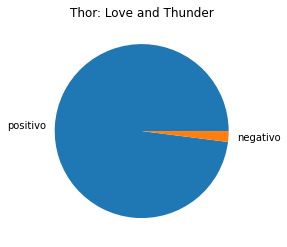

In [38]:
plt.pie([thor_pos,thor_neg], labels = ['positivo','negativo'])
plt.title("Thor: Love and Thunder")
plt.show()

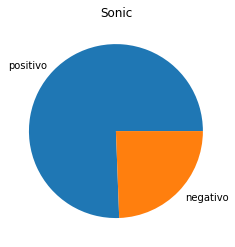

In [39]:
plt.pie([Sonic_pos,Sonic_neg], labels = ['positivo','negativo'])
plt.title("Sonic")
plt.show() 


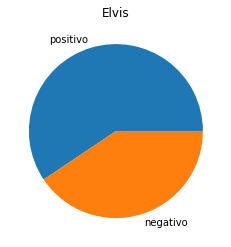

In [40]:
plt.pie([elvis_pos,elvis_neg], labels = ['positivo','negativo'])
plt.title("Elvis")
plt.show() 